In [4]:
# 对一张3d图片进行测试

import SimpleITK as sitk
import os

image = sitk.ReadImage('/home/tianyu/Desktop/data_base/Init_data/MASK/MASK_000.nrrd')
nda = sitk.GetArrayFromImage(image)

z_dim, y_dim, x_dim = nda.shape

output_dir = 'output_slices_mask'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

for i in range(z_dim):
    slice_2d = nda[i, :, :]
    
    slice_2d_image = sitk.GetImageFromArray(slice_2d)
    
    sitk.WriteImage(slice_2d_image, os.path.join(output_dir, 'slice_{:03d}.nrrd'.format(i)))

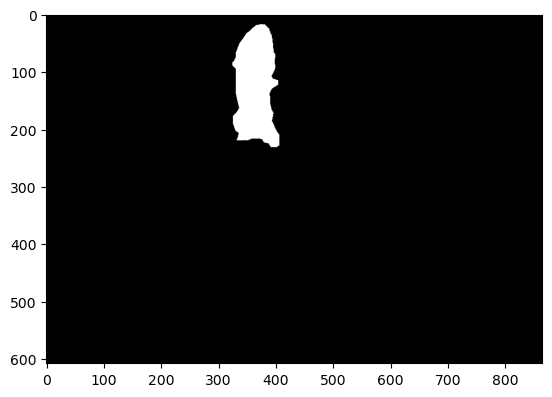

In [12]:
# 展示一张图片的结果

import SimpleITK as sitk

image_2d = sitk.ReadImage('output_slices_mask/slice_250.nrrd')

nda_2d = sitk.GetArrayFromImage(image_2d)

import matplotlib.pyplot as plt

plt.imshow(nda_2d, cmap='gray')
plt.show()



In [3]:
# 对一个方向，拆分成一组slice

import SimpleITK as sitk
import os
import numpy as np

def save_slices(nda, base_filename, output_dir):

    z_dim, y_dim, x_dim = nda.shape

    if not os.path.exists(output_dir):
        os.mkdir(output_dir)

    for i in range(z_dim):
        slice_2d = nda[i, :, :]
        
        slice_2d_image = sitk.GetImageFromArray(slice_2d)
        
        filename = os.path.join(output_dir, '{}_{:03d}.nrrd'.format(base_filename, i))
        
        sitk.WriteImage(slice_2d_image, filename)


In [8]:
image_dir = '/home/tianyu/Desktop/data_base/Init_data/DATA'
mask_dir = '/home/tianyu/Desktop/data_base/Init_data/MASK'
output_image_dir = '/media/tianyu/fanty/output_slices/xy/DATA'
output_mask_dir = '/media/tianyu/fanty/output_slices/xy/MASK'

image_filenames = os.listdir(image_dir)

for image_filename in image_filenames:

    if not image_filename.endswith('.nrrd'):
        continue
        
    
    
    data_filename = os.path.splitext(image_filename)[0]
    mask_filename = data_filename.replace("DATA", "MASK", 1)
    
    image = sitk.ReadImage(os.path.join(image_dir, image_filename))
    image_filename = image_filename.replace("DATA", "MASK", 1)
    mask = sitk.ReadImage(os.path.join(mask_dir, image_filename))
    
    nda_image = sitk.GetArrayFromImage(image)
    nda_mask = sitk.GetArrayFromImage(mask)
    
    save_slices(nda_image, data_filename, output_image_dir)
    save_slices(nda_mask, mask_filename, output_mask_dir)

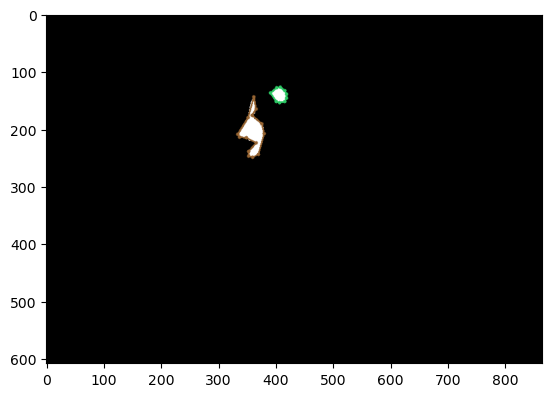

Shape 1: [(0.4185, 0.2368), (0.4069, 0.2961), (0.3861, 0.3438), (0.3896, 0.352), (0.4035, 0.3536), (0.4231, 0.3684), (0.4081, 0.3931), (0.4081, 0.4062), (0.4162, 0.4095), (0.4277, 0.4013), (0.4393, 0.3421), (0.4347, 0.3141), (0.415, 0.2895), (0.4231, 0.2714)]
Shape 2: [(0.4717, 0.2089), (0.4647, 0.2105), (0.452, 0.2253), (0.4636, 0.25), (0.4705, 0.2533), (0.4809, 0.25), (0.4844, 0.2401), (0.4844, 0.2286), (0.4809, 0.2188)]


In [18]:
# 对一张图片进行获取边界点测试

import cv2
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

mask_image = sitk.ReadImage('output_slices_mask/slice_262.nrrd')
mask = sitk.GetArrayFromImage(mask_image)

mask = (mask * 255).astype(np.uint8)

mask_3channel = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

shapes = []

height, width = mask.shape

for i, contour in enumerate(contours):
    epsilon = 0.01 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    
    vertices = []
    for point in approx:
        normalized_point = (round(point[0][0] / width, 4), round(point[0][1] / height, 4))
        vertices.append(normalized_point)
    
    shapes.append(vertices)
    
    color = ((i+1)*50 % 256, (i+1)*100 % 256, (i+1)*150 % 256)
    
    cv2.polylines(mask_3channel, [approx], True, color, 2)
    
    for point in approx:
        cv2.circle(mask_3channel, tuple(point[0]), 3, color, -1)

plt.imshow(cv2.cvtColor(mask_3channel, cv2.COLOR_BGR2RGB))
plt.show()

for i, shape in enumerate(shapes):
    print(f'Shape {i+1}: {shape}')



In [2]:
# 对一组3dmask图像 提取边界节点以及label 生成yolotxt格式

import os
import cv2
import numpy as np
import SimpleITK as sitk
import pandas as pd

df = pd.read_csv('/home/tianyu/Desktop/data_base/labels.csv')
mask_dir = '/home/tianyu/Desktop/data_base/Init_data/MASK'
save_dir = '/media/tianyu/fanty/output_slices/xy/LABEL'


index = 0

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for filename in sorted(os.listdir(mask_dir)):
    if filename.endswith('.nrrd'):
        mask_image = sitk.ReadImage(os.path.join(mask_dir, filename))
        mask_3d = sitk.GetArrayFromImage(mask_image)

        class_label = df.loc[index, 'label']
        class_index = 1 if class_label == 'M' else 0

        for i in range(mask_3d.shape[0]):
            mask = mask_3d[i, :, :]

            mask = (mask * 255).astype(np.uint8)

            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            height, width = mask.shape

            with open(os.path.join(save_dir, f'{filename[:-5]}_{i}.txt'), 'w') as f:
                for contour in contours:
                    epsilon = 0.01 * cv2.arcLength(contour, True)
                    approx = cv2.approxPolyDP(contour, epsilon, True)

                    if len(approx) > 0:  
                        f.write(str(class_index))  
                        for point in approx:
                            normalized_point = (round(point[0][0] / width, 4), round(point[0][1] / height, 4))
                            f.write(f' {normalized_point[0]} {normalized_point[1]}')
                        f.write('\n')

        index += 1
